In [1]:
%matplotlib inline

In [2]:
import hcipy as hci
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '../Utils'))
import plot as meplot
sys.path.remove(os.path.join(sys.path[0], '../Utils'))

# WARNING MESSAGE (this doesn't work at all)

"While Fresnel propagation can be used in the way that you want it to,
you need to add the lens phase yourself (this is what ThinLens is
supposed to do). You then need to either take extreme care when sampling
(you need to resolve the phase that you now put on; typically one pixel
should have a size on the order of 1-2 micron), or you need to have
adaptive algorithms that take care of this in some other way."

In [4]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.origin'] = True

## **Parameters**

In [5]:
wvlgth = 1e-6 #666e-9  

diam_aperture = 1.2           
focal_length = 18*diam_aperture 

diam_obs = 0.3/diam_aperture                                 # obscuration ratio
nb_spid = 4                                                  # [m]
spid_width = 0.05                                            # [m]

print('Wavelength = {} m'.format(wvlgth))
print('Aperture = {} m'.format(diam_aperture))
print('Focal length = {x:.3f} m \n'.format(x=focal_length))
print('Fresnel number = {x:.3f}'.format(x=diam_aperture**2/(wvlgth*focal_length)))

Wavelength = 1e-06 m
Aperture = 1.2 m
Focal length = 21.600 m 

Fresnel number = 66666.667


In [6]:
grid_size_pix = 1024
grid_diam = 1.5*diam_aperture

In [7]:
pupil_grid = hci.make_pupil_grid(grid_size_pix, grid_diam)  #It's a computational grid, nothing physical
print('On pupil plane, there is {} m/pix'.format(pupil_grid.delta))  #same as grid_diam/grid_size_pix
print('This is not a real pixel ! This is for the computation\'s sake')

On pupil plane, there is [0.00175953 0.00175953] m/pix
This is not a real pixel ! This is for the computation's sake


## **Aperture Auxtel (spiders + central obscuration)**

In [8]:
central_obs = hci.aperture.make_obstructed_circular_aperture(diam_aperture, diam_obs)
spider_1 = hci.aperture.make_spider([0,0], [0.6,0.6], spid_width)         # [m][m]
spider_2 = hci.aperture.make_spider([0,0], [0.6,-0.6], spid_width)        # [m][m]
spider_3 = hci.aperture.make_spider([0,0], [-0.6,0.6], spid_width)        # [m][m]
spider_4 = hci.aperture.make_spider([0,0], [-0.6,-0.6], spid_width)       # [m][m]

tel_pupil = central_obs(pupil_grid)*spider_1(pupil_grid)*spider_2(pupil_grid)*spider_3(pupil_grid)*spider_4(pupil_grid)

```Python
hci.imshow_field(tel_pupil, cmap='gray')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Aperture')
```

In [9]:
wf = hci.Wavefront(tel_pupil, wvlgth)

## **Lens**

In [10]:
wf2 = wf.copy()

k_0 = 2*np.pi/wvlgth                                               #résultat plus cohérent ?  1#
dist_squared = pupil_grid.x**2+pupil_grid.y**2

values = np.exp(1j * k_0 * dist_squared / (2*focal_length))
wf2.electric_field *= values

## **Plots (to check) before propagation**

/home/novae/rey/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


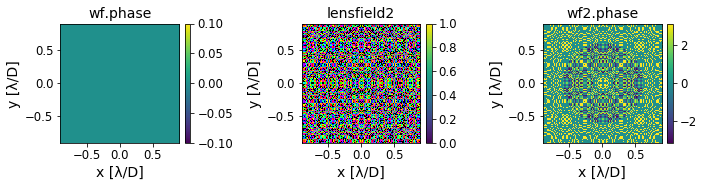

In [11]:
plt.subplot(1, 3, 1)
hci.imshow_field(wf.phase)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('wf.phase')

lensfield2 = hci.Field(values, pupil_grid)                          #just to see the field
plt.subplot(1, 3, 2)
hci.imshow_field(lensfield2)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('lensfield2')

plt.subplot(1, 3, 3)
hci.imshow_field(wf2.phase)
plt.colorbar(fraction=0.046, pad=0.04)
#plt.get_cmap('RdBu_r')
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('wf2.phase')

plt.tight_layout()
plt.show()

/home/novae/rey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


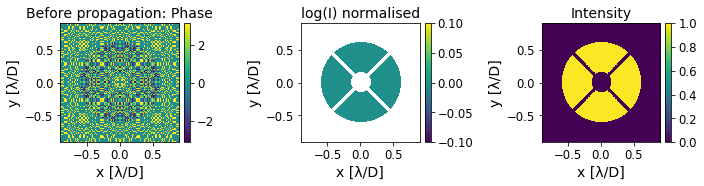

In [12]:
plt.subplot(1, 3, 1)
hci.imshow_field(wf2.phase)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('Before propagation: Phase')

plt.subplot(1, 3, 2)
hci.imshow_field(np.log(wf2.intensity/wf2.intensity.max())) #min -4, -3 = plus nice
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('log(I) normalised')

plt.subplot(1, 3, 3)
hci.imshow_field(wf2.intensity) #min -4, -3 = plus nice
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('Intensity')

plt.tight_layout()
plt.show()

## **Sampling**

To modelise the sampling, the `focal_grid` is used with `sampl_focal` (8 pixels per λ/D)

---
In POPPY, the equivalent is the `osys.add_detector` with a pixel size `pixsize` (0.1 micron)

In [13]:
sampl_focal = 16                                              #échantillonage q (8samples per λ/D) 
fov = 128                                     # [λ/D], radius

focal_grid = hci.make_focal_grid(pupil_grid, sampl_focal, fov)

print('Sampling at focal = {} pixels per λ/D'.format(sampl_focal))
print('Field of view = {} λ/D'.format(fov))

Sampling at focal = 16 pixels per λ/D
Field of view = 128 λ/D


In [14]:
pixsize = (wvlgth/(diam_aperture))/(8*10**-6)
print('The size of a pixel is {} micron'.format(pixsize))

The size of a pixel is 0.10416666666666667 micron


## **Propagation**

In [15]:
prop = hci.FresnelPropagator(pupil_grid, focal_length)
focal_image = prop.forward(wf)
focal_image2 = prop.forward(wf2)              # Defocus !

/home/novae/rey/anaconda3/lib/python3.7/site-packages/hcipy/fourier/fast_fourier_transform.py:70: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  f[self.cutout_input] = (field.ravel() * self.weights * self.shift_output).reshape(self.shape_in)
/home/novae/rey/anaconda3/lib/python3.7/site-packages/hcipy/fourier/fast_fourier_transform.py:72: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  res = res[self.cutout_output].ravel() * self.shift_input
/home/novae/rey/anaconda3/lib/python3.7/site-packages/hcipy/fourier/fast_fourier_transform.py:81: Futu

In [16]:
print(np.sum(focal_image.intensity))
print(np.sum(focal_image2.intensity))

if 0.9<np.sum(focal_image.intensity)/np.sum(focal_image2.intensity)<1.1:
    print ("vouais, ça passe (<10%)")
elif 0.8<np.sum(focal_image.intensity)/np.sum(focal_image2.intensity)<1.2:
    print ("hmmm entre 10% et 20% quand même")
else:
    print ("naaaaaah (>20%)")

312751.99999999994
312751.9999999999
vouais, ça passe (<10%)


## **Plots**

In [17]:
print('1 λ/D = {} arcsec'.format(fov*180*3600/np.pi*wvlgth/diam_aperture))

1 λ/D = 22.001579333023614 arcsec


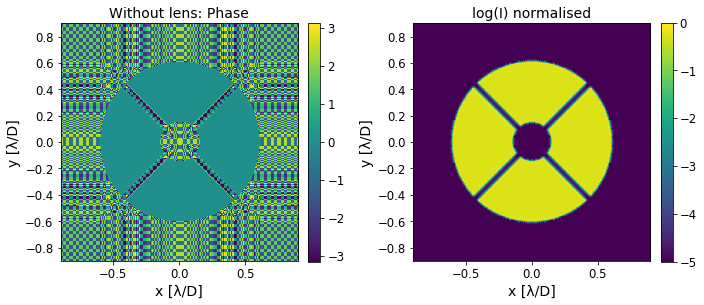

In [18]:
plt.subplot(1, 2, 1)
hci.imshow_field(focal_image.phase)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('Without lens: Phase')

plt.subplot(1, 2, 2)
hci.imshow_field(np.log10(focal_image.intensity / focal_image.intensity.max()), vmin=-5) #min -4, -3 = plus nice
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('log(I) normalised')

plt.tight_layout()
plt.show()

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                                 k0 = 6283185.307179587
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


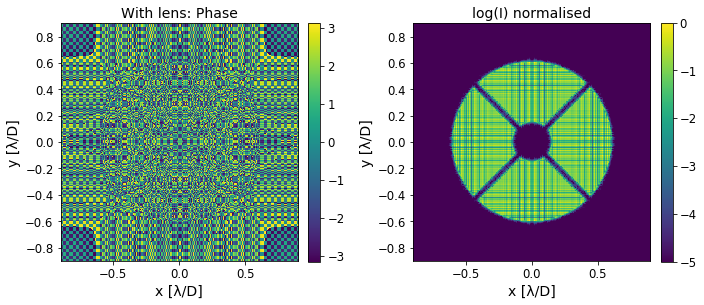

In [19]:
print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
print("                                 k0 = {}".format(k_0))
print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    
plt.subplot(1, 2, 1)
hci.imshow_field(focal_image2.phase)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('With lens: Phase')

plt.subplot(1, 2, 2)
hci.imshow_field(np.log10(focal_image2.intensity / focal_image2.intensity.max()), vmin=-5) #min -4, -3 = plus nice
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('log(I) normalised')

plt.tight_layout()
plt.show()

## **PSF**

In [20]:
int_map_1 = focal_image.intensity.shaped                         # Take intensity and reshape (1D -> 2D)
int_map_2 = focal_image2.intensity.shaped  

xaxis_1 = focal_grid.x.reshape(int_map_1.shape)[0,:]
xaxis_2 = focal_grid.x.reshape(int_map_2.shape)[0,:]

ValueError: cannot reshape array of size 16777216 into shape (1024,1024)

In [ ]:
meplot.slicum_focetdefoc(int_map_1, int_map_2, xaxis_1, xaxis_2, 
                      logscale=True, normalised=True)

meplot.foc_VS_defoc(int_map_1, int_map_2, xaxis_1, xaxis_2, 
                  logscale=True, normalised=True, wantslice=True)